# Denoising and deblurring

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 12})

In this chapter we will apply the things we learned about filtering to denoising and deblurring. We will take a statistical perspective. The resulting algorithms will thus be an application of linear regression to these important problems. We will explore properties and limitations of linear algorithms.

## Denoising

```{table} Notation.
:name: notation-table

| Objects | Notation |
|---|---|
| Deterministic scalars | $x$, $y$, $\alpha$|
| Random scalars | $\rx$, $\ry$ |
| Deterministic vectors | $\vx$, $\vy$ |
| Random vectors | $\rvx$, $\rvy$ |
| Deterministic matrices | $\mA$, $\mB$ |
| Random matrices | $\rmA$, $\rmB$ |
```

Image denoising is a fundamental image restoration method. Even though it is an old problem, there is a steady stream of creative new approaches, in particular based on deep learning. Denoising is also a basic building block in more complicated systems, for example diffusion–based generative models for images. NB: you could show this? Next year?
Denoising algorithms are used in digital cameras in low light conditions. 

Let's first load an image and add noise to it.

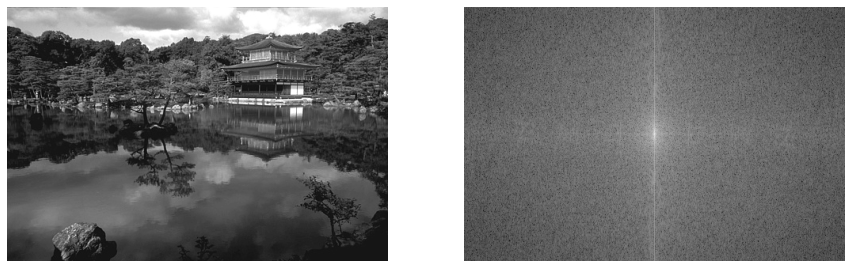

In [2]:
from skimage import io
from scipy.fftpack import fft2, ifft2, fftshift
from skimage import color

img = io.imread("./images/behringer.png")
img = io.imread("/Users/dokman0000/Downloads/BSR500/BSDS500/data/images/train/65010.jpg")
img_bw = color.rgb2gray(img[:, :, :3])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
F_img_bw = fftshift(fft2(img_bw))
axs[0].imshow(img_bw, cmap='gray')
axs[1].imshow(np.log(np.abs(F_img_bw)), cmap='gray')
for ax in axs: ax.axis('off')

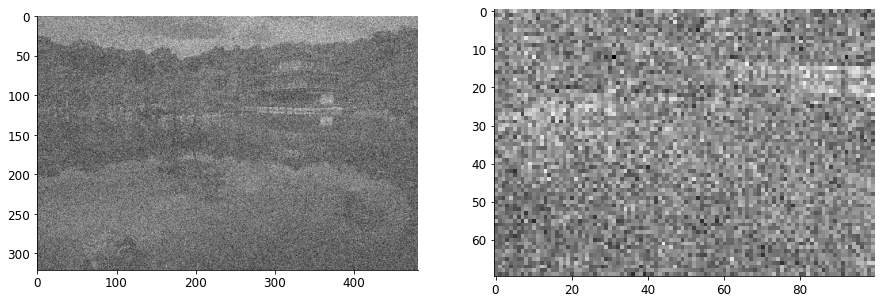

In [3]:
img_bw /= img_bw.max()
img_bw -= img_bw.mean()
sigma = 0.3
img_noise = img_bw + sigma*np.random.randn(*img_bw.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(img_noise, cmap='gray')
# axs[1].imshow(img_noise[500:875, 1000:1500], cmap='gray');
axs[1].imshow(img_noise[100:170, 200:300], cmap='gray');

Our task will be to denoise the noisy image. A quick-and-dirty strategy we've already seen at work for boundary detection is to apply a bit of Gaussian blur.

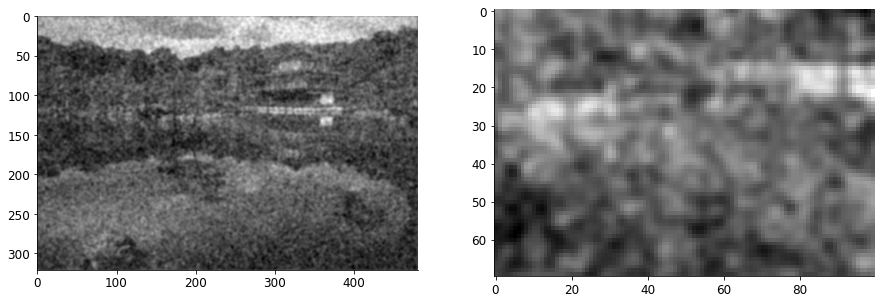

In [4]:
from scipy.signal import gaussian, convolve2d
from scipy.signal import fftconvolve

kernel_size = 7
h = gaussian(kernel_size, kernel_size / 5).reshape(kernel_size, 1)
h = np.dot(h, h.T)
h /= np.sum(h)
    
x_hat = fftconvolve(img_noise, h, mode='same')

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(x_hat, cmap='gray')
axs[1].imshow(x_hat[100:170, 200:300], cmap='gray');

This seems to indeed remove some noise (as well as signal), but is it the best we can do? As we've already seen a couple of times, answering this question will force us to define what we mean by _best_.

We model the clean image, the noise, and the noisy image as $d$-dimensional random vectors $\rvx$, $\rvw$, $\rvy$ and write

$$
  \rvy = \rvx + \rvw.
$$

Note that we are using our notation for a random vector rather than a random matrix. The reason for this is that we think of matrices as operators that are being applied to a vector. On the other hand we never want to "apply an image to a vector". It is more useful to conserve the semantics of operators and vectors than the fact that images are 2D arrays of numbers.

Another thing to note is that we model the uncorrupted images $\rvx$ as a random vector. This will be useful.

At this point the efforts we invested into understanding (Bayesian) linear regression will pay of a handsome dividend. We want to build an estimator $\hat{\rvx} = \hat{\rvx}(\rvy)$ of the underlying clean image $\rvx$. We want this estimator to be optimal in some sense, so we have to choose a quality metric. It is common to choose the mean-squared error (MSE) which is given for any estimator as

$$
  \mathrm{MSE}(\hat{\rvx}) = \EE ~ \norm{\hat{\rvx} - \rvx}^2.
$$

We then want to find an estimator which achieves the smallest possible MSE. It is possible to show that this minimum-MSE (MMSE) estimator is given as the conditional expectation

$$
  \hat{\rvx} = \EE [\rvx \mid \rvy] = \int \vx p(\vx | \rvy) d \vx.
$$

Indeed, we can compute as follows (recall that the estimate $\hat{\rvx}$ is _some_ function of the "observation" $\rvy$ so we write $\hat{\rvx} = g(\rvy)$),

$$
\begin{aligned}
  \EE ~ \norm{\hat{\rvx} - \rvx}^2 
  &= \EE ~ \norm{\hat{\rvx} - \rvx}^2 \\
  &= \EE\left\{ \EE \left[\norm{g(\rvy) - \rvx}^2 \mid \rvy \right]\right\},
\end{aligned}
$$
where we used the so-called tower property of conditional expectation, also known as the law of iterated expectation. A rigorous definition is quite technical, but we don't have to worry about it here. What is says in a nutshell is that the unconditional expectation can be computed by first computing the conditional expectation and then averaging all together. It expresses the following formal calculation:

$$
\begin{align}
  \int f(\vx, \vy) p_{\rvx, \rvy}(\vx, \vy) d\vx d\vy
\end{align}
$$

What this means effectively is that we can focus on the inner expectation and try to minimize it for each $\vy$ independently (since that will guarantee that the outer expectation or the outer integral is also the smallest possible). So we'd like to solve

$$
\begin{aligned}
  \min_{g(\vy)} \EE \left[\norm{g(\vy) - \rvx}^2 \mid \rvy = \vy \right]
\end{aligned}
$$

Taking the derivative (gradient) with respect to $g(\vy)$ (note that this is just some fixed vector which we could call anything we like, for example $\vv$) and setting to zero yields

$$
  2 \EE [ (g(\vy) - \rvx) \mid \rvy = \vy] = 0
  \Rightarrow
  g(\vy) = \EE [\rvx \mid \rvy = \vy].
$$

Now we've got our function $g$. Here $g$ is applied to a fixed vector $\vy$; in estimation we apply it to the random noisy observation $\rvy$ so we write

$$
  \hat{\rvx} = g(\rvy) = \EE [\rvx \mid \rvy].
$$

This formula holds generally, for any jointly distributed random vectors $\rvx$ and $\rvy$, not only for the additive noise model. It can be simplified in the latter case. This is quite fantastic, but in order to compute this optimal estimate it now turns out that we need to know the joint distribution of $(\rvx, \rvy)$, or at least the distribution of $\rvx$ conditioned on $\rvy$. In problems with real images this distribution is very complicated and we do not know it. It is also complicated to estimate from data.

### LMMSE Estimation

One problem with the above scheme is that there were no constraints on the estimator function (algorithm) $g$. Since $g$ can be very general, it can truly exploit the fine properties of the conditional probability distribution. We now try something different: we constrain $g$ to be a linear (or more precisely, affine) function.

Let $\vmu = \EE \rvx = \EE \rvy$ (recall that we work with zero-mean noise). We will look for an estimate of $\rvx$ of the form

$$
  \hat{\rvx} = \mH (\rvy - \vmu) + \vmu.
$$

(The reason to subtract the mean is to improve the conditioning of $\mH$. TODO: add a picture.) We want to find the matrix $\mH$ which gives the best MSE:

$$
  \mathrm{minimize}_{\mH \in \RR^{d \times d}} \EE \| \mH(\rvy - \vmu) + \vmu - \rvx \|^2.
$$

By taking the gradient of the loss with respect to $\mH$ and setting it to zero, we find that the optimal $\mH$ is

$$
  \mH = \mSigma_{\rvx\rvx} (\mSigma_{\rvx\rvx} + \sigma^2 \mI)^{-1},
$$

where $\mSigma_{\rvx\rvx}$ is the covariance matrix of the random vector $\rvx$,

$$
  \mSigma_{\rvx\rvx} = \EE (\rvx - \vmu) (\rvx - \vmu)^T.
$$

The LMMSE estimator is thus given as

$$
  \hat{\rvx} = \mSigma_{\rvx\rvx} (\mSigma_{\rvx\rvx} + \sigma^2 \mI)^{-1} (\rvy - \vmu) + \vmu
$$

This is noteworthy: if we restrict the class of estimators $g$ to only linear estimators, then we do not need to know the distribution of $\rvx$ but only its mean and covariance matrix. Mean and covariance are in general much simpler to estimate than the full distribution.

Instead of the additive Gaussian noise model, we could have simply started with some jointly distributed random vectors $(\rvx, \rvy)$. The LMMSE estimator would then read

$$
  \hat{\rvx} = \mH (\rvy - \vmu_\rvy) + \vmu_\rvx,
$$

where 

$$
\begin{align}
  \mH &= \mSigma_{\rvx \rvy} \mSigma_{\rvy \rvy}^{-1}\\
  \mSigma_{\rvx \rvy} &= \EE (\rvx - \vmu_\rvx)(\rvy - \vmu_\rvy)^T\\
  \mSigma_{\rvy \rvy} &= \EE (\rvy - \vmu_\rvy)(\rvy - \vmu_\rvy)^T.
\end{align}
$$

Check that this is indeed the case following the template we laid down earlier. You might need this someday! The previous result for additive white Gaussian noise follows immediately.

It is also interesting to record the actual MSE achieved by the LMMSE estimator. It is given as

$$
\begin{aligned}
  \mathrm{LMMSE} 
  &= \mathrm{Tr} (\mSigma_{\rvx\rvx} - \mSigma_{\hat{\rvx} \hat{\rvx}}) \\
  &= \sum_{i=1}^d \left[\mathrm{Var}(\rx_i) - \mathrm{Var}(\hat{\rx}_i)\right] \\
  &= \sum_{i=1}^d \left[\EE(\rx_i^2) - \EE(\hat{\rx}_i^2)\right].
\end{aligned}
$$

Do check that these equalities really hold!

A final note about Gaussianity. We've seen that the LMMSE estimator only needs means and covariances. Gaussian distributions are completely determined by means and covariances. In fact, one can show that when $\rvx$ and $\rvy$ are jointly Gaussian random vectors, then the LMMSE estimator is in fact the MMSE estimator.

## Wiener filter

The LMMSE estimator is sometimes called the Wiener filter, but the real Wiener filter usually implies a little bit more. To motivate this ``little bit more'', let us consider how we could estimate the matrix $\mSigma_{\rvx\rvx}$ (or any of the other involved covariance matrices). We would usually have a dataset of images $\{\vx_1, \ldots, \vx_n\}$ that we believe are iid samples from the unknown underlying distribution of $\rvx$. We would then form an estimate of the covariance as 

$$
  \hat{\mSigma}_{\rvx\rvx} = \frac{1}{n} \sum_{i=1}^n (\vx_i - \hat{\vmu}_\rvx)( \vx_i - \hat{\vmu}_\rvx)^T,
$$

where

$$
  \hat{\mu}_{\rvx} = \frac{1}{n} \sum_{i=1}^n \vx_i.
$$

Sometimes you will see the factor $\frac{1}{n}$ replaced by $\frac{1}{n-1}$ in the covariance estimate (but not the mean estimate). For our purpose that is irrelevant (it yields an ``unbiased'' estimate).

Now if we work with $256 \times 256$ RGB images, the dimension of $\vx_i$ is 

$$ 
  d = 256 \times 256 \times 3 = 196,608.
$$

The covariance matrix is thus of dimensions $d \times d = 196,608 \times 196,608$ which is huge. There are about $38,654,705,664 / 2$ entries to estimate (it's a symmetric matrix), and this requires an enormous training set. Further, manipulating a matrix of this size (say, inverting it) is very very challenging on standard hardware.

The saving grace comes from noting that a good denoising operator should perform a similar operation in every part of the image. If we additionally want it to be linear, then we can further constrain the class of admissible estimators to convolutional filters. In other words, we can further constrain the matrix (the linear operator) $\mH$ to be a convolution matrix. (TODO: update the notation table.) Letting $h[\vn]$ with $\vn = (n_1, n_2)$ be the corresponding impulse response, and $\rx[\vn], \ry[\vn], \rw[\vn]$ be the images corresponding to vectors $\rvx, \rvy, \rvw$, we then have

$$
  \hat{\rx}[\vn] = (\ry \circledast \rh)[\vn].
$$

Ultimately we want to use linear convolution, but let us for the moment pretend that circular convolution is fine since it will simplify the derivations. (TODO: use $2N$ below.) Applying the discrete Fourier transform on both sides we get

$$
  \hat{\rX}[\vk] = \rY[\vk] \cdot H[\vk]
$$ (dft-wiener)

where we use the upper case to denote the corresponding DFTs. The key benefit of passing to the (discrete) frequency domain is that the frequency-domain filter coefficient become independent of one another. In other words, in the equation {eq}`dft-wiener` we can choose each of the $\rH[\vk]$ independently of all others, and it will only depend on $\rX[\vk]$ and $\rY[\vk]$ for that particular $\vk$. To see this we use the Parseval equality. Indeed, since

$$
  \EE \sum_{\vn \in \ZZ_d^2} (\rx[\vn] - \hat{\rx}[\vn])^2
  =
  \frac{1}{d^2} \EE \sum_{\vk \in \ZZ_d^2} (\rX[\vk] - \hat{\rX}[\vk])^2  
$$
($\sum_{\vn \in \ZZ_d^2}$ is just fancy notation for $\sum_{n_1=0}^{d-1} \sum_{n_2=0}^{d-1}$), we can do our minimization in the frequency domain where it now simply reads

$$
  \min_{H} \EE \sum_{\vk \in \ZZ_d^2} (H[\vk] \rY[\vk] - \rX[\vk])^2
  =
  \min_{H} \sum_{\vk \in \ZZ_d^2} \EE |H[\vk] \rY[\vk] - \rX[\vk]|^2
$$

which can indeed be solved for each $\vk$ independently. Note that we have to put $\| \cdot \|$ around the terms in the frequency domain since they are in general complex. Taking the derivative with respect to the real and imaginary parts of $H[\vell]$ and setting them to zero yields (do check this!)

$$
  \EE (H[\vell] Y[\vell] - X[\vell]) Y^*[\vell] = 0,
$$

so that

$$
  H[\vell] = \frac{S_{XY}[\vell]}{S_{YY}[\vell]},
$$
where $S_{XY}[\vell] = \EE ~ X[\vell] Y^*[\vell]$ and $S_{YY}[\vell] = \EE ~ Y[\vell] Y^*[\vell]$.

For additive white Gaussian noise we have that (do check the following as well!)

$$
  S_{XY}[\vell] = S_{XX}[\vell] = \EE ~ X[\vell] Y^*[\vell]
$$

and

$$
  S_{YY}[\vell] = S_{XX}[\vell] + S_{WW}[\vell] =  S_{XX}[\vell] + d^2 \sigma^2
$$

so that

$$
  H[\vell] = \frac{S_{XX}[\vell]}{S_{XX}[\vell] + d^2 \sigma^2}
$$

We can now identify an implicit assumption, or an alternative route that would've yielded a convolutional filter model



## Deblurring



## Effects of circular convolution



## Notes

- There is a more pleasing derivation of the MMSE estimator without differentiation. Do it for the non-conditional expectation. (Optimizing over constant functions.)
- Add the regression function / conditional expectation in the lecture on regression.
- Comment on data efficiency for full vs